In [1]:
from linalg import *
from misc import *
from models import *
from models.utils import get_layer_idxs
from evaluate import *
from data import *
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams["figure.figsize"] = (6.5,4.5)
font = {'family': 'sans-serif','size': 18}
mpl.rc('font', **font)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f'[device: {device} is ready]')

data = Circles(
    path='data/downloads',
    to_transform=False)

model = Demo(
    device=device,
    in_shape=data.in_shape,
    num_classes=data.num_classes,
    temperature=1,
    dtype=torch.float64,
    activation='ReLU')

w = get_trainable_parameters(model)
idxs = get_layer_idxs(model)
num_layers = len(idxs)

seeds = 3

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[device: cpu is ready]


## Recreating the Goldilocks Zone

100%|█████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.69it/s]


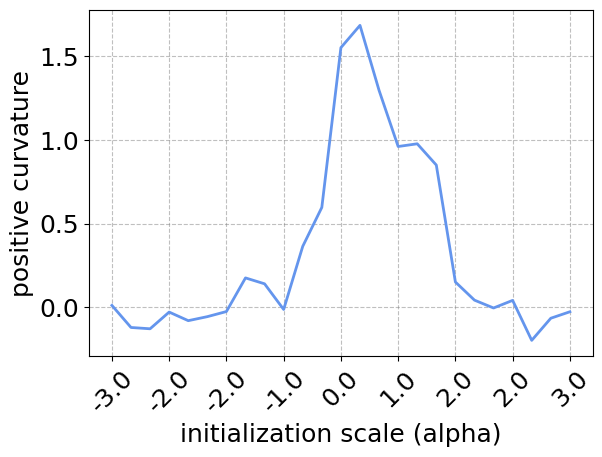

In [2]:
# By scaling the initialization

model.set_temperature(1.)
scales = 10**np.arange(-3,3.25,0.25)
curvs = np.zeros((seeds, len(scales)))

for seed in range(seeds):
    for scale_id in tqdm(range(len(scales))):
        set_trainable_parameters(model, scales[scale_id]*w)
        _, curv = goldilocks(model, data.datasets["train"], 50, device)
        curvs[seed][scale_id] = curv
        
plt.plot(curvs.mean(0), color='cornflowerblue', linewidth=2)
plt.xticks(
        range(len(scales))[::3],
        [round(np.log10(scale),0) for scale in scales][::3],
        rotation=45)
plt.xlabel('initialization scale (alpha)')
plt.ylabel('positive curvature')
plt.grid(ls='dashed', color='grey', alpha=0.5)

100%|█████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.86it/s]


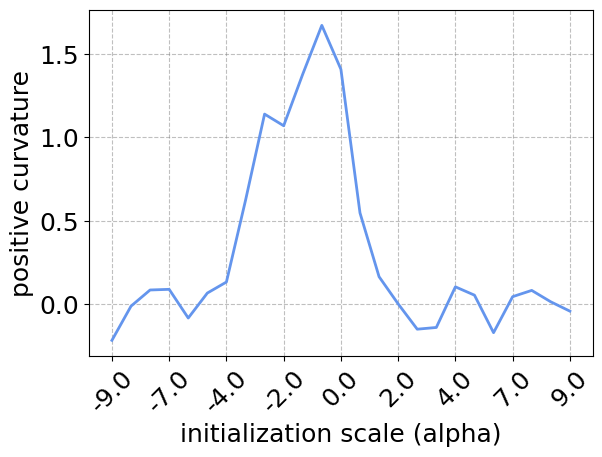

In [3]:
# By scaling the softmax temperature

set_trainable_parameters(model, w)
temps = 10**np.arange(-3*num_layers,3*num_layers+0.25*num_layers,0.25*num_layers)
curvs = np.zeros((seeds, len(scales)))

for seed in range(seeds):
    for temp_id in tqdm(range(len(temps))):
        model.set_temperature(temps[temp_id])
        _, curv = goldilocks(model, data.datasets["train"], 50, device)
        curvs[seed][temp_id] = curv
        
plt.plot(curvs.mean(0), color='cornflowerblue', linewidth=2)
plt.xticks(
        range(len(temps))[::3],
        [round(np.log10(temp),0) for temp in temps][::3],
        rotation=45)
plt.xlabel('initialization scale (alpha)')
plt.ylabel('positive curvature')
plt.grid(ls='dashed', color='grey', alpha=0.5)

## Gauss-Newton decomposition & spectral norm

In [4]:
model.set_temperature(1.)
scales = 10**np.arange(-3,3,0.25)
R = get_random_ortho_matrix(w.numel(), 50, device).to(model.dtype)
curvs = {
    'G': np.zeros((seeds, len(scales))),
    'H': np.zeros((seeds, len(scales))),
    'Hessian': np.zeros((seeds, len(scales)))}
norms = {
    'G': np.zeros((seeds, len(scales))),
    'H': np.zeros((seeds, len(scales))),
    'Hessian': np.zeros((seeds, len(scales)))}

for seed in range(seeds):
    for scale_id in tqdm(range(len(scales))):
        set_trainable_parameters(model, scales[scale_id]*w)
        J = get_Jacobian(model, data.datasets["train"], data.num_classes, R)
        p = F.softmax(model.predict(data.datasets["train"]), dim=-1).detach()
        G_term = get_G_term(J, p)
        L_G = torch.real(torch.linalg.eig(G_term)[0])
        curvs['G'][seed][scale_id] = L_G.sum()/L_G.norm() if L_G.norm()>0 else 0
        norms['G'][seed][scale_id] = L_G.max()
        Hessian = hessian(model, data.datasets["train"], True, R)
        L_Hessian = torch.real(torch.linalg.eig(Hessian)[0])
        curvs['Hessian'][seed][scale_id] = L_Hessian.sum()/L_Hessian.norm()
        norms['Hessian'][seed][scale_id] = L_Hessian.max()
        H_term = Hessian - G_term
        L_H = torch.real(torch.linalg.eig(H_term)[0])
        curvs['H'][seed][scale_id] = L_H.sum()/L_H.norm()
        norms['H'][seed][scale_id] = L_H.max()

100%|█████████████████████████████████████████████████████| 24/24 [01:13<00:00,  3.05s/it]


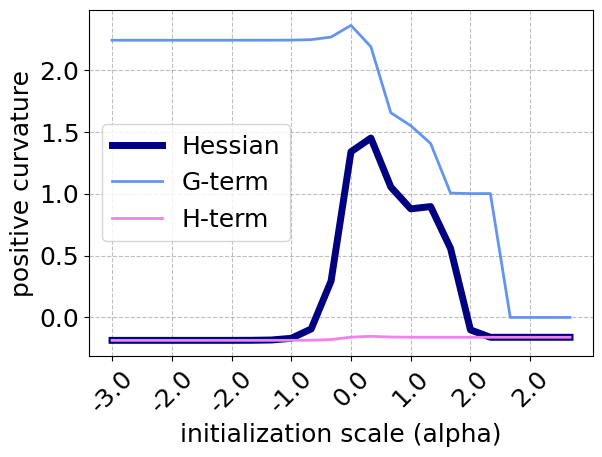

In [5]:
# Positive curvature of the G-term, H-term, and the Hessian

plt.plot(curvs['Hessian'].mean(0), color='navy', linewidth=5, label='Hessian')
plt.plot(curvs['G'].mean(0), color='cornflowerblue', linewidth=2, label='G-term')
plt.plot(curvs['H'].mean(0), color='violet', linewidth=2, label='H-term')
plt.xticks(
        range(len(scales))[::3],
        [round(np.log10(scale),0) for scale in scales][::3],
        rotation=45)
plt.xlabel('initialization scale (alpha)')
plt.ylabel('positive curvature')
plt.grid(ls='dashed', color='grey', alpha=0.5)
plt.legend()

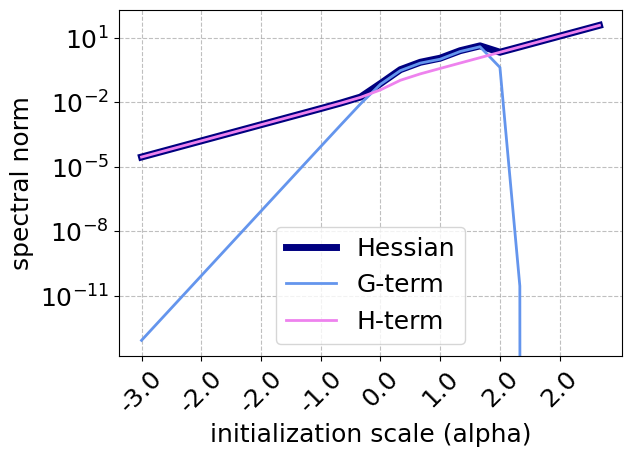

In [6]:
# Spectral norm of the G-term, H-term, and the Hessian

plt.plot(norms['Hessian'].mean(0), color='navy', linewidth=5, label='Hessian')
plt.plot(norms['G'].mean(0), color='cornflowerblue', linewidth=2, label='G-term')
plt.plot(norms['H'].mean(0), color='violet', linewidth=2, label='H-term')
plt.xticks(
        range(len(scales))[::3],
        [round(np.log10(scale),0) for scale in scales][::3],
        rotation=45)
plt.xlabel('initialization scale (alpha)')
plt.ylabel('spectral norm')
plt.grid(ls='dashed', color='grey', alpha=0.5)
plt.legend()
plt.yscale('log')

## Expected G-term

In [7]:
model.set_temperature(1.)
scales = 10**np.arange(-3,3,0.25)
curvs_G = np.zeros((seeds, len(scales)))
curvs_EG = np.zeros((seeds, len(scales)))
R = get_random_ortho_matrix(w.numel(), 50, device).to(model.dtype)

for seed in range(seeds):
    for scale_id in tqdm(range(len(scales))):
        set_trainable_parameters(model, scales[scale_id]*w)
        J = get_Jacobian(model, data.datasets["train"], data.num_classes, R)
        p = F.softmax(model.predict(data.datasets["train"]), dim=-1).detach()
        var_C = (J.mean(0).std([0,1]))**2
        cs = J.mean(0, keepdim=True)
        cs = cs.repeat(J.shape[0],1,1)
        var_E = ((J-cs).std([0,1,2]))**2
        G_term = get_G_term(J, p)
        L_G = torch.real(torch.linalg.eig(G_term)[0])
        curvs_G[seed][scale_id] = L_G.sum()/L_G.norm() if L_G.norm()>0 else 0 
        curvs_EG[seed][scale_id] = EG_curvature(var_E, var_C, R.shape[0], p)

100%|█████████████████████████████████████████████████████| 24/24 [01:07<00:00,  2.83s/it]


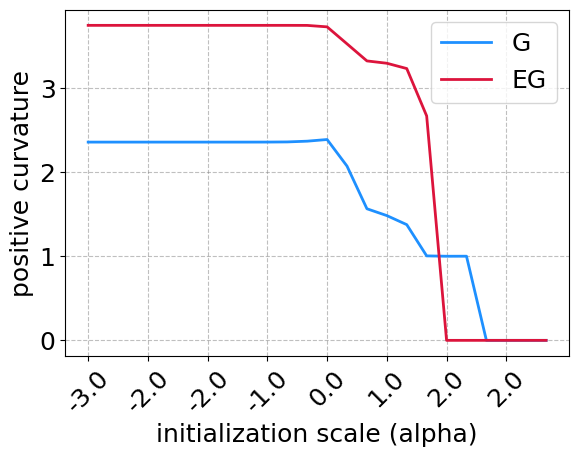

In [8]:
# Positive curvature of the empirical G-term and the expected G-term

plt.plot(curvs_G.mean(0), color='dodgerblue', linewidth=2, label='G')
plt.plot(curvs_EG.mean(0), color='crimson', linewidth=2, label='EG')
plt.xticks(
        range(len(scales))[::3],
        [round(np.log10(scale),0) for scale in scales][::3],
        rotation=45)
plt.xlabel('initialization scale (alpha)')
plt.ylabel('positive curvature')
plt.grid(ls='dashed', color='grey', alpha=0.5)
plt.legend()

## Expected gradient & more

In [9]:
num_samples = 500
model.set_temperature(1.)
set_trainable_parameters(model, w)

R = get_random_ortho_matrix(w.numel(), 50, device).to(model.dtype)
J = get_Jacobian(model, data.datasets["train"], data.num_classes, R)
var_C = (J.mean(0).std([0,1]))**2
Q = get_prior(data.datasets["train"].targets, data.num_classes)

g_norms = np.zeros((num_samples,))
prior_dist = np.zeros((num_samples,))
losses = np.zeros((num_samples,))
avg_entropy = np.zeros((num_samples,))
curvs = np.zeros((num_samples,))

for i in tqdm(range(num_samples)):
    model.zero_grad()
    model.initialize()
    out = model.predict(data.datasets["train"])
    p = F.softmax(out, dim=-1).detach().cpu()
    avg_entropy[i] = Categorical(p).entropy().mean(0)
    loss = F.cross_entropy(out, data.datasets["train"].targets.to(device))
    loss.backward()
    losses[i] = loss.item()
    g = get_current_gradients(model).detach()
    g_norms[i] = g.norm()
    prior_dist[i] = (Q-p.mean(0)).norm()
    curv = goldilocks(model, data.datasets["train"], 50, device)[1]
    curvs[i] = curv

100%|███████████████████████████████████████████████████| 500/500 [02:57<00:00,  2.81it/s]


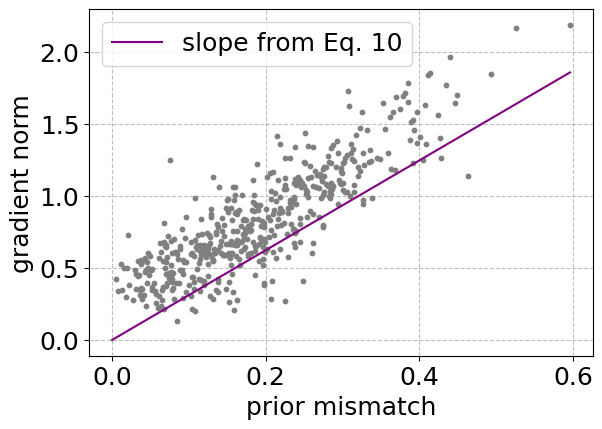

In [10]:
# Gradient norms vs. prior mismatch

plt.scatter(prior_dist, g_norms, s=10, color='grey')
plt.plot([0,prior_dist.max()],[0, R.shape[1]*np.sqrt(var_C)*prior_dist.max()], color='purple', label='slope from Eq. 10')
plt.xlabel('prior mismatch')
plt.ylabel('gradient norm')
plt.grid(ls='dashed', color='grey', alpha=0.5)
plt.legend()

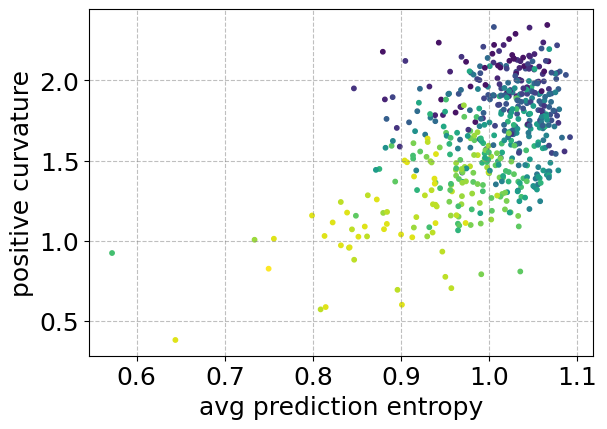

In [11]:
# The inteplay between output entropy, positive curvature, and initial loss

bins = [np.quantile(losses, i) for i in np.linspace(0,1,20)]
idxs = np.digitize(losses, bins)
cmap = plt.get_cmap('viridis')
colors = np.array([cmap(i) for i in np.linspace(0,1,len(bins)+1)])
plt.scatter(avg_entropy, curvs, s=10, color=colors[idxs])
plt.xlabel('avg prediction entropy')
plt.ylabel('positive curvature')
plt.grid(ls='dashed', color='grey', alpha=0.5)

## Top Hessian eigenvector before softmax collapse

In [13]:
data = FMNIST(
    path='data/downloads',
    to_transform=False)

model = LeNet300100(
    device=device,
    in_shape=data.in_shape,
    num_classes=data.num_classes,
    temperature=1,
    dtype=torch.float64,
    activation='ReLU')

w = get_trainable_parameters(model)

In [ ]:
scales = [5, 10, 30, 60, 100, 200]
fig, axes = plt.subplots(ncols=len(scales), nrows=1, figsize=(10,2))
for scale_id in tqdm(range(len(scales))):
    set_trainable_parameters(model, scales[scale_id]*w)
    _, V = eigenthings(
            model=model,
            loss=F.cross_entropy,
            dataset=data.datasets["train"],
            num_things=1)
    img = V.squeeze()[:784*300].reshape(300,784)
    img = img.mean(axis=0).reshape(data.in_shape).squeeze()
    axes[scale_id].imshow(img, cmap='viridis')
    axes[scale_id].set_xticklabels(labels=[])
    axes[scale_id].set_yticklabels(labels=[])
    axes[scale_id].set_title(f'{scales[scale_id]}')

  0%|                                                               | 0/6 [00:00<?, ?it/s]